# Методы ИИ в анализе данных. Часть 1

Датасет:
[FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)
 

In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import librosa
import librosa.display


plt.rcParams['figure.figsize'] = (17, 10)
data = pd.read_csv('data/data.csv')

# Используемые признаки

## MFCC (Мел-частотные кепстральные коэффициенты)


Шкала Мел соотносит воспринимаемую частоту или высоту чистого тона (мел) с фактической измеренной
частотой (Гц).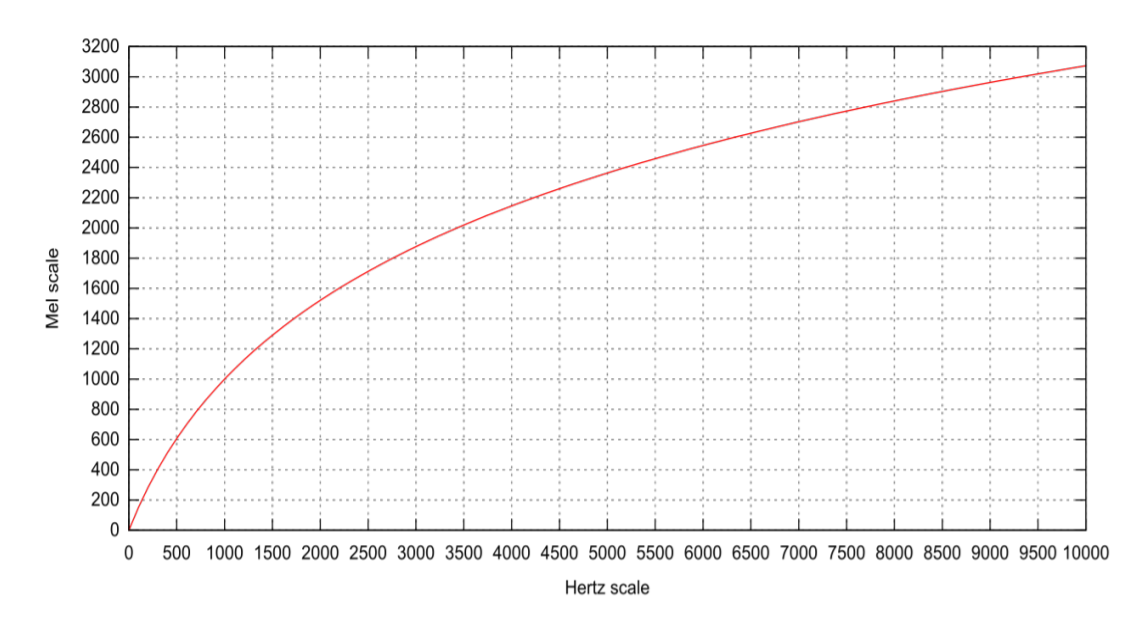


Вычисление мел-частотных кепстральных коэффициентов включает в себя следующие шаги:
1. Необходимо разделить исходный сигнал на фреймы. Размер фрейма обычно выбирается от 20 до 40 мс,
так как считается, что речевой сигнал на этом промежутке не сильно меняется.
2. Речевой сигнал конечен и не является периодическим, поэтому из-за разрывов на его концах при применении преобразования Фурье проявляется эффект утечки. Для того, чтобы снизить его влияние на результат,
каждый кадр умножается на оконную функцию Хемминга. К получившемуся результату применяем дискретное преобразование Фурье.
3. Вычисляем периодограмму для каждого фрейма (усредненный по фрейму квадрат результата, полученного на предыдущем шаге)
4. Вычисляем блок мел-фильтров. Для этого треугольные фильтры (от 20 до 40) умножаются на периодограмму и суммируются. В результате мы получим энергии набора фильтров.
5. Полученные энергии логарифмируются. Это также мотивируется человеческим слухом: мы не слышим
громкость в линейном масштабе.
6. Далее, используя дискретное косинусное преобразование, получим мел-кепстральные коэффициенты.

В датасете посчитаны 20 коэффициентов по окнам, на которые разбита песня. И для каждой псоледовательности коэффициента расчитаны статистики:  mean, standard deviation, skew, kurtosis, median, minimum and maximum

c:\users\arkol\pycharmprojects\mtai\venv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\arkol\pycharmprojects\mtai\venv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


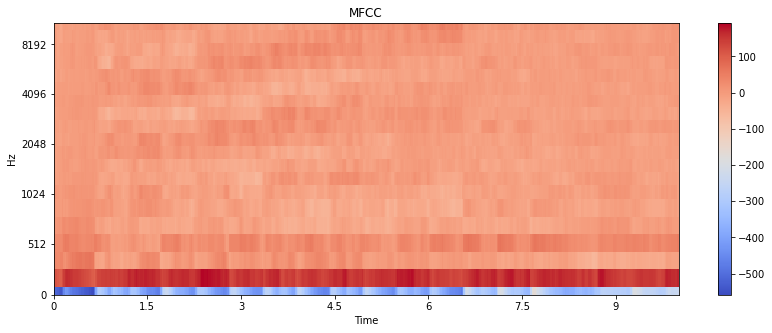

In [2]:
y, sr = librosa.load(librosa.ex('nutcracker'), duration=10, offset=10)
mfccs = librosa.feature.mfcc(y, sr, n_mfcc=20)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('MFCC')
ipd.Audio(data=y, rate=sr)

## Tonnetz

Данный признак позволяет оценить наличие гармонии в сигнале, выделить характерные интервалы.

Алгоритм преобразования:
1. Вычисляется constant-q преообразование. В отличие от преобразования фурье, constant-q выделяет частоты по логарифмической шкале, в соотвествии с тем, как их выделяет наш слух.

2. Полученные частоты преобразуются в 12-мерный вектор, каждая компента которого соотвествует суммарной амплитуде частот, соотвествующей одной ступени хроматической последовательности нот, которая называется гармоническим классом (0 - C, 1 - C#, 2 - D и т.д.). Ноты разных октав приводятся к одному гармоническому классу.

3. Далее следует преобразование 12-мерного вектора $с_n$ для данного фрейма в вектор 6-мерного пространства $\zeta_n$, в котором гармонические классы, образующие квинту, большую и малую терции имеют малое евклидовое расстояние. 

$$\zeta_n(d) = \frac{1}{||c_n||_1} \sum_{l=0}^{11} \Phi(d, l)c_n(l),$$
где $0 \leq d \leq 5$, $0 \leq l \leq 11$,

$\Phi = [\phi_0, \phi_1, ..., \phi_{11} ]$ - матрица перехода, где

$\phi_l = \begin{pmatrix}
  \Phi(0, l)\\ 
  \Phi(1, l)\\
  ...\\
  \Phi(5, l)
\end{pmatrix} = \begin{pmatrix}
  r_1 sin(l\frac{7\pi}{6})\\ 
  r_1 cos(l\frac{7\pi}{6})\\
  r_2 sin(l\frac{3\pi}{2})\\ 
  r_2 cos(l\frac{3\pi}{2})\\
  r_3 sin(l\frac{2\pi}{3})\\ 
  r_3 cos(l\frac{2\pi}{3})
\end{pmatrix},$
где $r_i$ соотвествуют вкладу соотвествующих интервалов(квинта, б\м терции) в расстояние, который определяются тем, насколько гармоничными мы воспринимаем эти интервалы и полагаются равными $r_1=r_2=1$, $r_3=0.5$

В данной работе используются различные статистики, вычисленные для этого признака по всем фреймам трека.

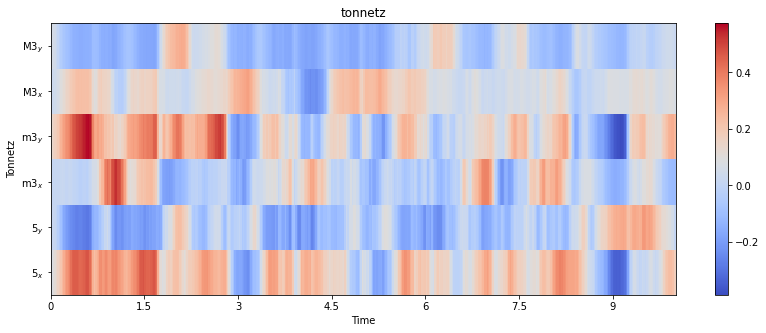

In [3]:
y, sr = librosa.load(librosa.ex('nutcracker'), duration=10, offset=10)
tonnetz = librosa.feature.tonnetz(y, sr=sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time')
plt.colorbar()
plt.title('tonnetz')
ipd.Audio(data=y, rate=sr)

## Temp

Темп относится к скорости музыкального произведения. Более точно, темп относится к скорости музыкального ритма и задается обратным периодом ритма. Темп часто определяется в единицах ударов в минуту (BPM (beats per minute))


Темп может варьироваться в пределах одной композиции. Поэтому можно ввести темпограмму как матрицу признаков, которая указывает на преобладание определенных темпов в каждый момент времени. Однако из-за серьёзно укороченных произведений в данных, была выбрана оценка глобального темпа всего музыкального произведения


c:\users\arkol\pycharmprojects\mtai\venv\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


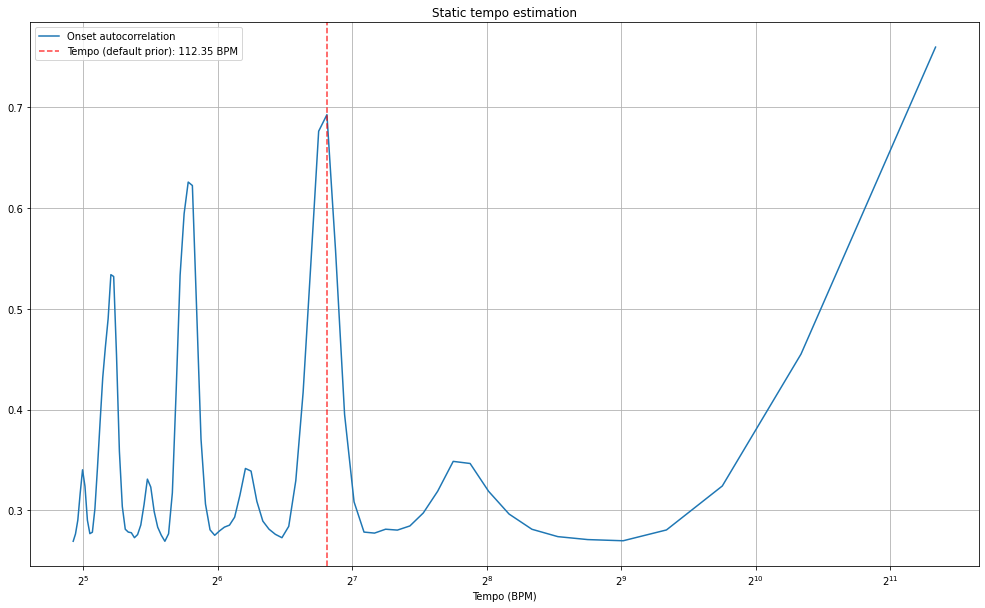

In [4]:
import matplotlib.pyplot as plt
import scipy.stats

x, sr = librosa.load(librosa.ex('nutcracker'), sr=None, mono=True, duration=30)
onset_env = librosa.onset.onset_strength(x, sr=sr)
tempo_short = librosa.beat.tempo(x, sr=sr)
prior = scipy.stats.uniform(30, 300)  # uniform over 30-300 BPM
utempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, prior=prior)

# Convert to scalar
tempo = tempo_short.item()
utempo = utempo.item()
# Compute 2-second windowed autocorrelation
hop_length = 512
ac = librosa.autocorrelate(onset_env, 2 * sr // hop_length)
freqs = librosa.tempo_frequencies(len(ac), sr=sr,
                                  hop_length=hop_length)
# Plot on a BPM axis.
fig, ax = plt.subplots()
ax.semilogx(freqs[1:], librosa.util.normalize(ac)[1:],
             label='Onset autocorrelation', basex=2)
ax.axvline(tempo, 0, 1, alpha=0.75, linestyle='--', color='r',
            label='Tempo (default prior): {:.2f} BPM'.format(tempo))
ax.set(xlabel='Tempo (BPM)', title='Static tempo estimation')
ax.grid(True)
ax.legend()

## Percusive and Harmonic components

Перкуссия - ударные инструменты. Ударная перкуссия сохраняет ритм и добавляет акцент и контраст музыке. 
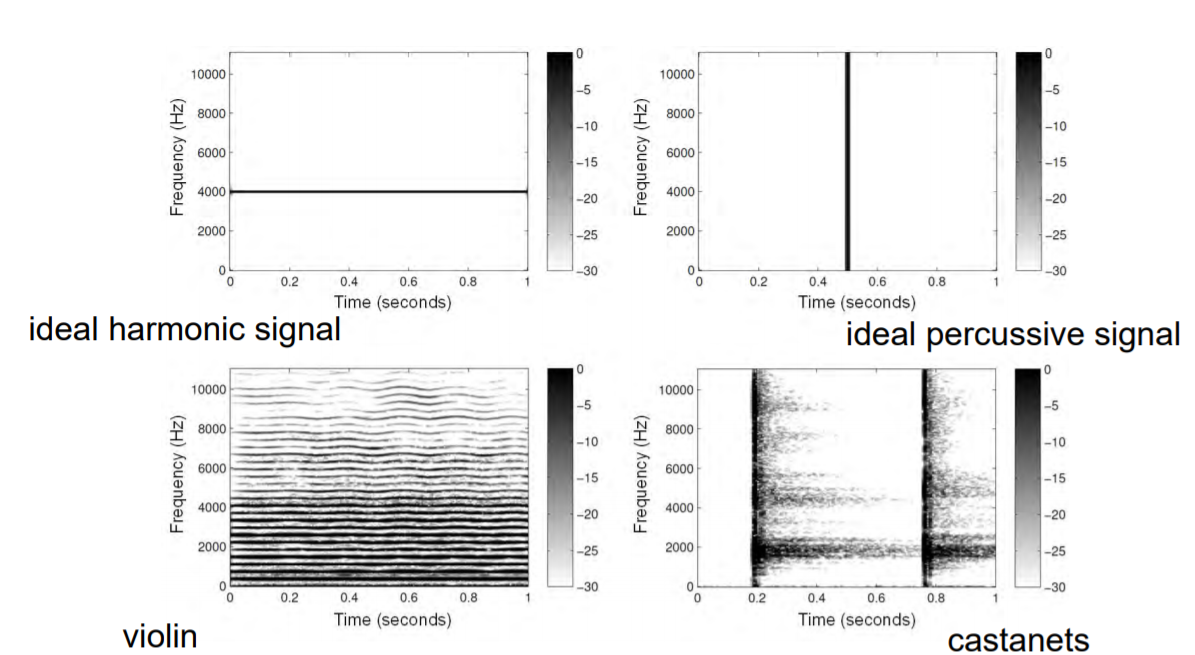

[Text(0.5, 1.0, 'Percussive')]

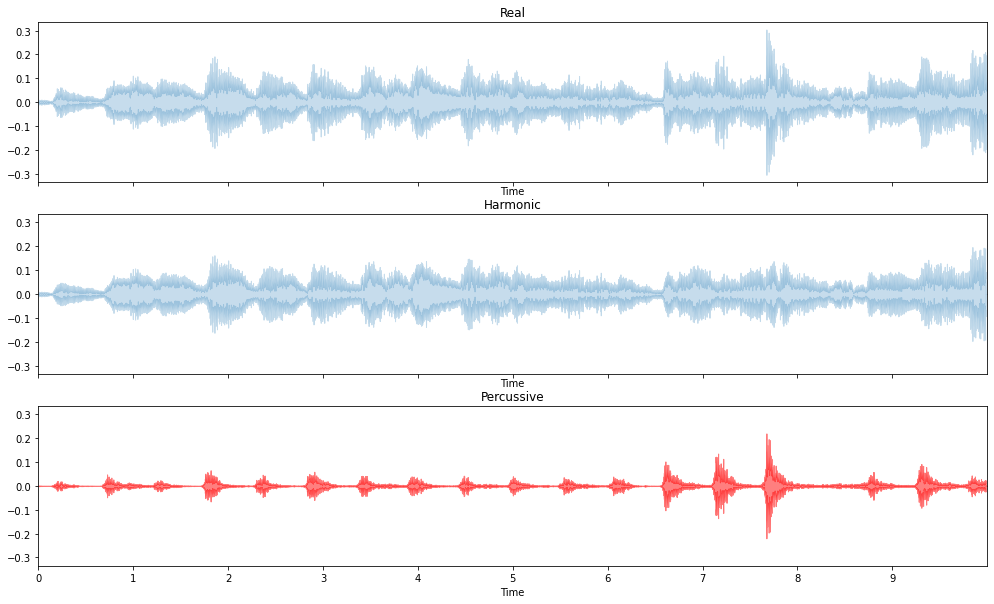

In [5]:
h, p = librosa.effects.hpss(y)

plt.rcParams['figure.figsize'] = (17, 10)
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
librosa.display.waveplot(y, sr=sr, alpha=0.25, ax=ax[0])
ax[0].set(title='Real')
librosa.display.waveplot(h, sr=sr, alpha=0.25, ax=ax[1])
ax[1].set(title='Harmonic')
librosa.display.waveplot(p, sr=sr, color='r', alpha=0.5, ax=ax[2])
ax[2].set(title='Percussive')

# Предобработка

In [2]:
target = 'genre_top'
features_all = [feature for feature in data.columns if 'genre_top'!=feature and 'track_id'!=feature]

In [3]:
y = data.loc[:, target]
X = data.loc[:, features_all]
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [4]:
ind_mfcc = []
ind_tonnetz = []
ind_perc_harm = []
ind_temp = []

for ind, feature in enumerate(features_all):
    if 'mfcc' in feature: ind_mfcc.append(ind)
    if 'tonnetz' in feature: ind_tonnetz.append(ind)
    if 'perc' in feature or 'harm' in feature: ind_perc_harm.append(ind)
    if 'temp' in feature: ind_temp.append(ind)

In [5]:
scaler = skl.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
def train_features(X_train, X_test, y_train, y_test, clf):
    print('Process mfcc features')
    clf.fit(X_train[:, ind_mfcc], y_train)
    y_predict = clf.predict(X_test[:, ind_mfcc])
    print('Accuracy: {:.2%}'.format(accuracy_score(y_test, y_predict)))
    print('F1: {:.2%}'.format(f1_score(y_test, y_predict, average="macro")))
    print('_____________________')
    
    print('Process tonnetz features')
    clf.fit(X_train[:, ind_tonnetz], y_train)
    y_predict = clf.predict(X_test[:, ind_tonnetz])
    print('Accuracy: {:.2%}'.format(accuracy_score(y_test, y_predict)))
    print('F1: {:.2%}'.format(f1_score(y_test, y_predict, average="macro")))
    print('_____________________')
    
    print('Process mfcc+tonnetz features')
    clf.fit(X_train[:, [*ind_mfcc, *ind_tonnetz]], y_train)
    y_predict = clf.predict(X_test[:, [*ind_mfcc, *ind_tonnetz]])
    print('Accuracy: {:.2%}'.format(accuracy_score(y_test, y_predict)))
    print('F1: {:.2%}'.format(f1_score(y_test, y_predict, average="macro")))
    print('_____________________')
    
    print('Process mfcc+tonnetz+harmonic/percussive features')
    clf.fit(X_train[:, [*ind_mfcc, *ind_tonnetz, *ind_perc_harm]], y_train)
    y_predict = clf.predict(X_test[:, [*ind_mfcc, *ind_tonnetz, *ind_perc_harm]])
    print('Accuracy: {:.2%}'.format(accuracy_score(y_test, y_predict)))
    print('F1: {:.2%}'.format(f1_score(y_test, y_predict, average="macro")))
    print('_____________________')
    
    print('Process mfcc+tonnetz+harmonic/percussive+temp features')
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    print('Accuracy: {:.2%}'.format(accuracy_score(y_test, y_predict)))
    print('F1: {:.2%}'.format(f1_score(y_test, y_predict, average="macro")))
    print('_____________________')

# Метод опорных векторов (SVM)

Прогоняем разные признаки для базовых настроек

In [9]:
train_features(X_train, X_test, y_train, y_test, skl.svm.SVC())

Process mfcc features
Accuracy: 56.83%
F1: 56.68%
_____________________
Process tonnetz features
Accuracy: 33.62%
F1: 32.67%
_____________________
Process mfcc+tonnetz features
Accuracy: 57.98%
F1: 57.75%
_____________________
Process mfcc+tonnetz+harmonic/percussive features
Accuracy: 58.13%
F1: 57.91%
_____________________
Process mfcc+tonnetz+harmonic/percussive+temp features
Accuracy: 58.28%
F1: 58.02%
_____________________


### Ищем оптимальные гиперпараметры

In [ ]:
clf_search = skl.svm.SVC()
kf = KFold(n_splits=3, shuffle=True, random_state=42)
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, 0.3, 1, 3, 10]}
gs = GridSearchCV(clf_search, parameters, 'f1_macro', -1, cv=kf)
gs.fit(X_train, y_train)
gs.cv_results_

{'mean_fit_time': array([  6.68649141,   7.82758927,   8.68919555,  11.37502146,
          6.6760145 ,   7.97758547,  32.3188711 ,   6.28332106,
          7.40174516,  92.70833214,   8.83873828,   7.29195778,
        312.35396489,   8.68155154,   8.14033071]),
 'mean_score_time': array([1.99713961, 2.76838072, 2.47700588, 1.92007248, 2.6089468 ,
        2.4133594 , 1.90319769, 2.54251655, 2.3500398 , 1.96684607,
        2.57008513, 2.28032072, 1.78373718, 2.61774262, 2.24866891]),
 'mean_test_score': array([0.50954881, 0.47607986, 0.29384734, 0.49533964, 0.52517369,
        0.37583275, 0.48821143, 0.56601   , 0.46482108, 0.48623646,
        0.57421338, 0.51091047, 0.48324416, 0.56701931, 0.53104217]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 0.3, 0.3, 0.3, 1, 1, 1, 3, 3, 3, 10, 10,
                    10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False],
        fill_value='?',
       

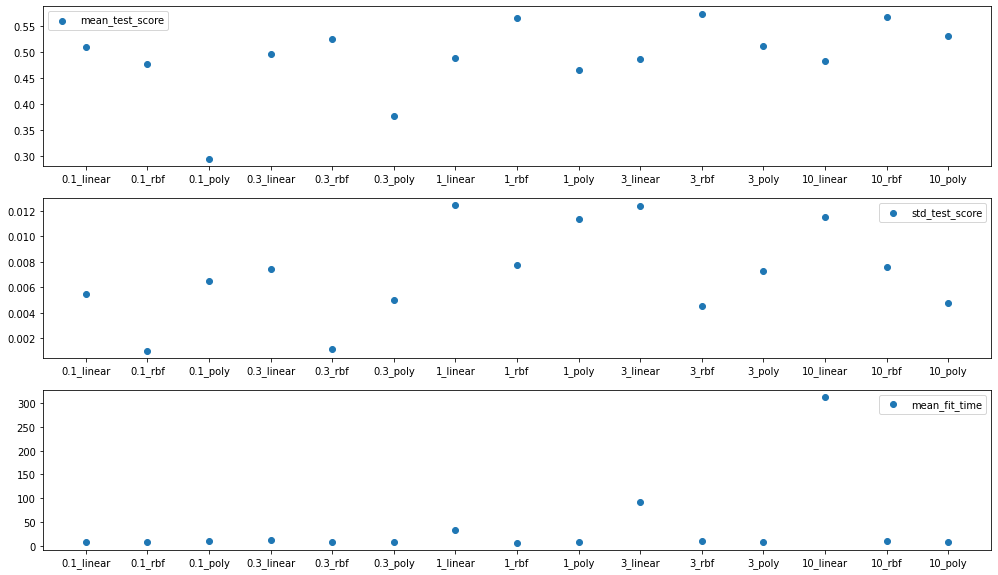

In [ ]:
xlabel = []
for i in range(len(gs.cv_results_['params'])):
    xlabel.append(str(gs.cv_results_['param_C'][i]) + '_' + gs.cv_results_['param_kernel'][i])

plt.subplot(3, 1, 1)
plt.scatter(xlabel, gs.cv_results_['mean_test_score'], label='mean_test_score')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(xlabel, gs.cv_results_['std_test_score'], label='std_test_score')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(xlabel, gs.cv_results_['mean_fit_time'], label='mean_fit_time')
plt.legend()

In [ ]:
%%time
clf = skl.svm.SVC(C=3, kernel='rbf')
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))
y_predict = clf.predict(X_test)
print('F1: {:.2%}'.format(f1_score(y_test, y_predict, average="macro")))

Accuracy: 60.13%
F1: 59.92%
CPU times: user 20.2 s, sys: 4.34 ms, total: 20.2 s
Wall time: 20.2 s


# Случайный лес 
Прогоняем разные признаки для базовых настроек

In [11]:
train_features(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42))

Process mfcc features
Accuracy: 52.28%
F1: 51.31%
_____________________
Process tonnetz features
Accuracy: 32.22%
F1: 31.38%
_____________________
Process mfcc+tonnetz features
Accuracy: 55.03%
F1: 54.15%
_____________________
Process mfcc+tonnetz+harmonic/percussive features
Accuracy: 54.78%
F1: 54.12%
_____________________
Process mfcc+tonnetz+harmonic/percussive+temp features
Accuracy: 54.78%
F1: 53.81%
_____________________


### Ищем оптимальные гиперпараметры

In [ ]:
rfc_search = RandomForestClassifier(oob_score=True)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
parameters = {'criterion':('gini', 'entropy'), 'n_estimators':[100, 200, 300, 500], "class_weight":['balanced', 'balanced_subsample'],}
gs = GridSearchCV(rfc_search, parameters, 'f1_macro', -1, cv=kf)
gs.fit(X_train, y_train)
gs.cv_results_

{'mean_fit_time': array([ 6.13891869, 12.65132794, 19.20189867, 33.33998857, 13.91909895,
        28.156285  , 41.82477841, 68.86114116,  6.8026792 , 13.64306083,
        20.56869884, 33.99021931, 14.04075475, 26.79846606, 35.00457783,
        47.8648603 ]),
 'std_fit_time': array([0.04237594, 0.10341316, 0.06346677, 0.23713461, 0.10086556,
        0.13626858, 0.05170849, 0.18077954, 0.03722991, 0.03043   ,
        0.06929946, 0.08399577, 0.06624957, 1.0275759 , 0.98065728,
        1.55034493]),
 'mean_score_time': array([0.05202374, 0.09915352, 0.13648634, 0.2164413 , 0.0515449 ,
        0.08905597, 0.1289124 , 0.21003509, 0.04993782, 0.09231782,
        0.1302639 , 0.20676761, 0.04912319, 0.07761993, 0.09077582,
        0.13253908]),
 'std_score_time': array([0.00252307, 0.00545137, 0.00217631, 0.01378024, 0.0025831 ,
        0.00298467, 0.00303043, 0.00382626, 0.00067666, 0.00452872,
        0.00112147, 0.00503896, 0.00119534, 0.00235983, 0.01023102,
        0.0049311 ]),
 'param_cl

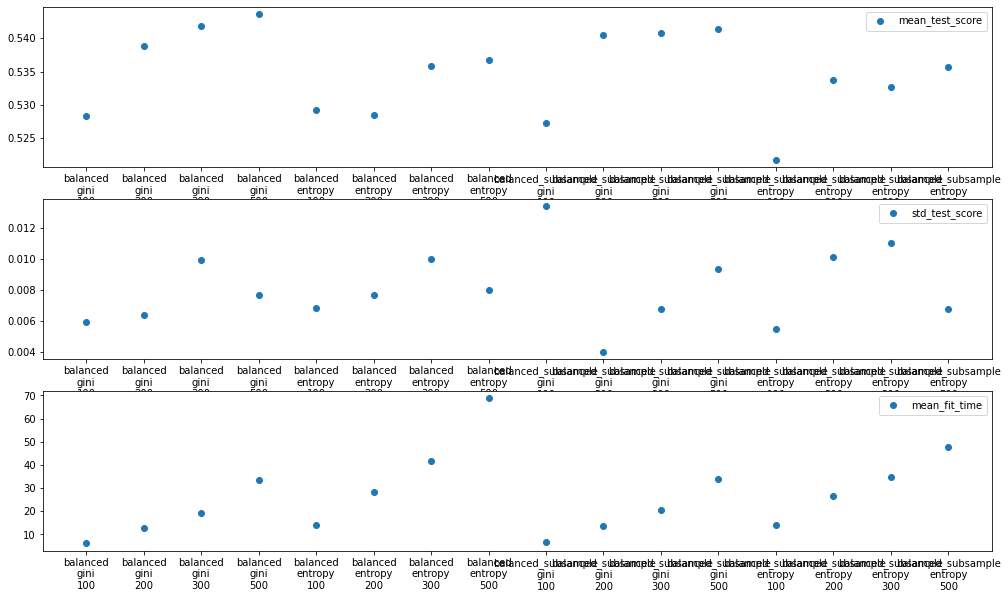

In [ ]:
xlabel = []
for i in range(len(gs.cv_results_['params'])):
    xlabel.append(str(gs.cv_results_['param_class_weight'][i]) + '\n' + gs.cv_results_['param_criterion'][i] + '\n' + str(gs.cv_results_['param_n_estimators'][i]))

plt.subplot(3, 1, 1)
plt.scatter(xlabel, gs.cv_results_['mean_test_score'], label='mean_test_score')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(xlabel, gs.cv_results_['std_test_score'], label='std_test_score')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(xlabel, gs.cv_results_['mean_fit_time'], label='mean_fit_time')
plt.legend()

In [ ]:
%%time
rfc = RandomForestClassifier(oob_score=True, n_estimators=500, class_weight="balanced")
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))
y_predict = rfc.predict(X_test)
print('F1: {:.2%}'.format(f1_score(y_test, y_predict, average="macro")))

Accuracy: 57.08%
F1: 56.03%
CPU times: user 39.2 s, sys: 191 ms, total: 39.4 s
Wall time: 39.5 s


# Градиентный бустинг
Прогоняем разные признаки для базовых настроек

In [12]:
train_features(X_train, X_test, y_train, y_test, GradientBoostingClassifier())

Process mfcc features
Accuracy: 52.88%
F1: 52.74%
_____________________
Process tonnetz features
Accuracy: 32.97%
F1: 32.43%
_____________________
Process mfcc+tonnetz features
Accuracy: 53.03%
F1: 52.88%
_____________________
Process mfcc+tonnetz+harmonic/percussive features
Accuracy: 53.63%
F1: 53.35%
_____________________
Process mfcc+tonnetz+harmonic/percussive+temp features
Accuracy: 53.98%
F1: 53.71%
_____________________


### Ищем оптимальные гиперпараметры

In [ ]:
gb_search = GradientBoostingClassifier()
kf = KFold(n_splits=3, shuffle=True, random_state=42)
parameters = {
              'learning_rate': [0.05, 0.1, 0.15],
              'n_estimators': [50, 100, 200],
              'subsample': [0.5, 1],
              'max_depth': [3, 5, 7]
             }
gs = GridSearchCV(gb_search, parameters, 'f1_macro', n_jobs=-1, cv=kf)
gs.fit(X_train, y_train)
gs.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}

In [ ]:
with open('search_gb.npy', 'wb') as file:
    np.save(file, gs.cv_results_)

In [ ]:
results = pd.DataFrame(gs.cv_results_)
results.drop(columns=['mean_fit_time', 'std_fit_time', 
                      'mean_score_time', 'std_score_time', 
                      'params', 'split0_test_score', 'split1_test_score',
                     'split2_test_score'], inplace=True)

In [ ]:
results.sort_values(by='rank_test_score')

,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score,rank_test_score
10,0.05,5,200,0.5,0.564814,0.007994,1
16,0.05,7,200,0.5,0.564540,0.004136,2
53,0.15,7,200,1,0.562851,0.001996,3
47,0.15,5,200,1,0.560699,0.006031,4
35,0.1,7,200,1,0.558368,0.006363,5
28,0.1,5,200,0.5,0.558135,0.003397,6
34,0.1,7,200,0.5,0.557933,0.002005,7
17,0.05,7,200,1,0.557729,0.010485,8
51,0.15,7,100,1,0.555208,0.006295,9
29,0.1,5,200,1,0.554546,0.006546,10


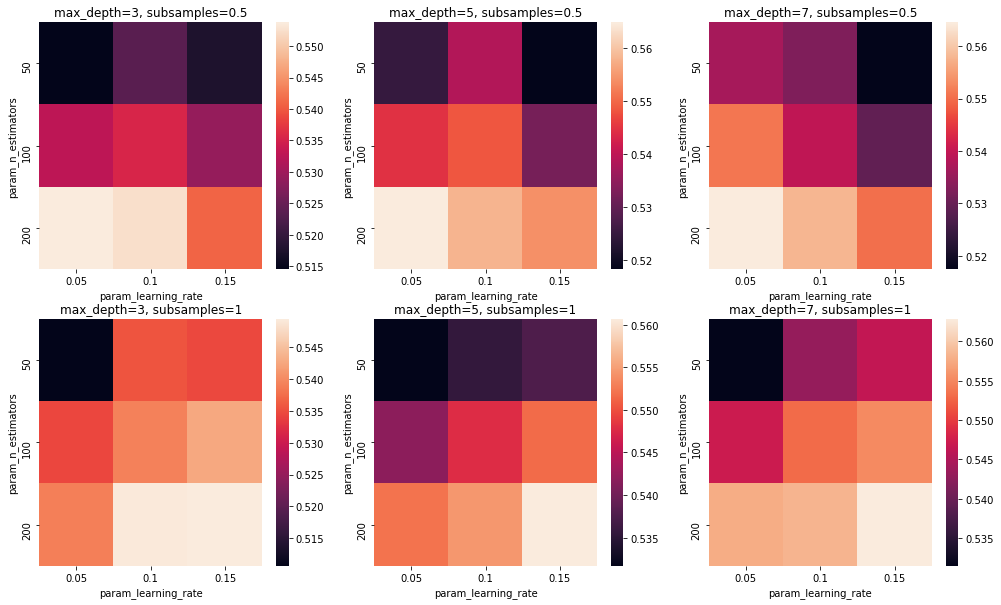

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3)
for i in range(2):
    for j in range(3):
        res = results[(results['param_max_depth'] == parameters['max_depth'][j]) & (results['param_subsample'] == parameters['subsample'][i])]
        data = res.pivot('param_n_estimators', 'param_learning_rate', 'mean_test_score')
        ax[i][j].set_title(f"max_depth={parameters['max_depth'][j]}, subsamples={parameters['subsample'][i]}")
        heatmap(data, ax=ax[i][j]);

In [ ]:
%%time
gb = gs.best_estimator_
gb.fit(X_train, y_train)
score = gb.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))
y_predict = gb.predict(X_test)
print('F1: {:.2%}'.format(f1_score(y_test, y_predict, average="macro")))

Accuracy: 57.13%
F1: 57.08%
CPU times: user 3min 30s, sys: 575 ms, total: 3min 30s
Wall time: 3min 32s


# Логистическая регрессия
Прогоняем разные признаки для базовых настроек

In [13]:
train_features(X_train, X_test, y_train, y_test, LogisticRegression(max_iter=500))

Process mfcc features
Accuracy: 50.68%
F1: 49.84%
_____________________
Process tonnetz features
Accuracy: 27.76%
F1: 27.14%
_____________________
Process mfcc+tonnetz features
Accuracy: 53.03%
F1: 52.55%
_____________________
Process mfcc+tonnetz+harmonic/percussive features
Accuracy: 53.58%
F1: 53.05%
_____________________
Process mfcc+tonnetz+harmonic/percussive+temp features
Accuracy: 53.68%
F1: 53.06%
_____________________


### Ищем оптимальные гиперпараметры

In [55]:
clf_search = LogisticRegression(max_iter = 500, random_state=42)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
parameters = {'C':[0.001, 0.003, 0.01, 0.03, 0.1], 'solver':['lbfgs', 'liblinear', 'newton-cg'], 'multi_class':['ovr', 'multinomial']}
gs = GridSearchCV(clf_search, parameters, 'f1_macro', -1, cv=kf)
gs.fit(X_train, y_train)
gs.cv_results_

c:\users\arkol\pycharmprojects\mtai\venv\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass scoring=f1_macro, n_jobs=-1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{'mean_fit_time': array([1.10833859, 3.27867341, 4.77401129, 0.88733729, 0.05333058,
        2.0989995 , 1.20734032, 3.90598655, 4.63767465, 1.08406432,
        0.04833603, 2.32100391, 1.91767375, 5.24399996, 5.29167724,
        1.19533157, 0.07233993, 2.94633412, 2.43098625, 7.84966445,
        6.17799536, 1.32065543, 0.03433498, 3.24566237, 4.20566559,
        9.87066992, 7.69498714, 2.82566381, 0.04166222, 3.18964378]),
 'std_fit_time': array([0.1722541 , 0.38571709, 0.15736553, 0.03425364, 0.01114686,
        0.10600345, 0.05526717, 0.22563859, 0.11269636, 0.08132333,
        0.0116725 , 0.18659421, 0.04983007, 0.27953795, 0.30347182,
        0.12637866, 0.01775542, 0.20114975, 0.03557846, 0.13496013,
        1.04165497, 0.03646823, 0.00189067, 0.21425   , 0.47733524,
        0.39610389, 0.34337766, 0.09035155, 0.0016989 , 0.83275499]),
 'mean_score_time': array([0.04533974, 0.03532942, 0.03399944, 0.04333019, 0.        ,
        0.04165681, 0.04165149, 0.03166477, 0.02799678, 0.04

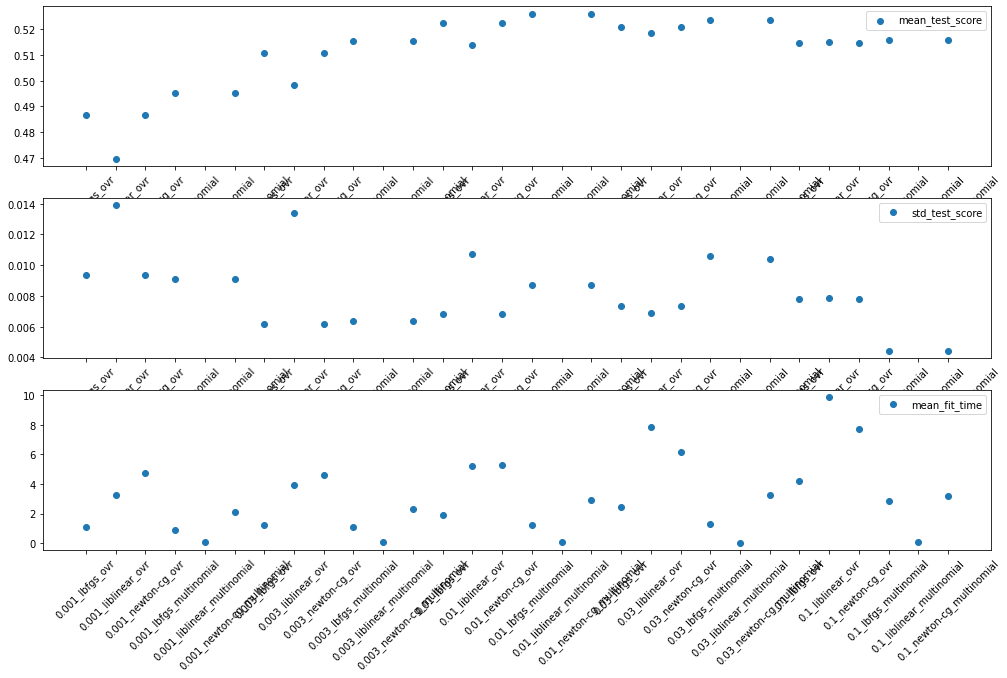

In [58]:
xlabel = []
for i in range(len(gs.cv_results_['params'])):
    xlabel.append(str(gs.cv_results_['param_C'][i]) + '_' + str(gs.cv_results_['param_solver'][i]) + '_' + str(gs.cv_results_['param_multi_class'][i]))

plt.subplot(3, 1, 1)
plt.xticks(rotation=45)
plt.scatter(xlabel, gs.cv_results_['mean_test_score'], label='mean_test_score')
plt.legend()

plt.subplot(3, 1, 2)
plt.xticks(rotation=45)
plt.scatter(xlabel, gs.cv_results_['std_test_score'], label='std_test_score')
plt.legend()

plt.subplot(3, 1, 3)
plt.xticks(rotation=45)
plt.scatter(xlabel, gs.cv_results_['mean_fit_time'], label='mean_fit_time')
plt.legend()

In [6]:
%%time
clf = LogisticRegression(max_iter=500, C=0.01, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))
y_predict = clf.predict(X_test)
print('F1: {:.2%}'.format(f1_score(y_test, y_predict, average="macro")))

Accuracy: 54.38%
F1: 53.59%
Wall time: 516 ms


# CatBoost
Прогоняем разные признаки для базовых настроек

In [15]:
train_features(X_train, X_test, y_train, y_test, CatBoostClassifier(thread_count=-1, random_seed=42, verbose=False))

Process mfcc features
Accuracy: 56.93%
F1: 56.59%
_____________________
Process tonnetz features
Accuracy: 33.87%
F1: 33.41%
_____________________
Process mfcc+tonnetz features
Accuracy: 58.43%
F1: 57.98%
_____________________
Process mfcc+tonnetz+harmonic/percussive features
Accuracy: 58.98%
F1: 58.65%
_____________________
Process mfcc+tonnetz+harmonic/percussive+temp features
Accuracy: 60.08%
F1: 59.76%
_____________________
